# ARIMA

ARIMA (AutoRegressive Integrated Moving Average) is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

### AR ( Autoregression ) 
- Relationship between present observations with past observations
> * p = lag observations ( lag order )

### I ( Integrrated ) d
- Differencing of raw obsevations ( Make the time series stationary )
> * d = degree of differencing 

### MA ( Moving Average ) q
- Tool that indicate overall trend direction.
- It takes how wrong the last time period was to predict the correct next period
> * q = order of moving average

In [1]:
#pip install --upgrade pandas pip install --upgrade pandas-datareader
#pip install pandas-datareader
import pandas_datareader as pdr
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from tqdm import tqdm_notebook
import numpy as np

import yfinance as yf
import statsmodels.api as sm

from itertools import product
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
%matplotlib inline


## Retrieve the data

In [2]:
# Retrieve Data
df = pdr.get_data_yahoo("BTC-USD")
df.shape

(1825, 6)

* the dataset retrieved via Yahoo finance API contains around 1800 entries (days) since 2017
* There are 6 columns ( High, Low, Close, Adj Close, Open, Volume ) 
* We are only interested in "Close" prices to perform ARIMA prediction.

The good thing about using such dataset is that very little preparation needs to be done:

* there are no missing values
* the date is already indexed. ( Very important for time series prediction )

## Visualise dataset

<Figure size 864x360 with 0 Axes>

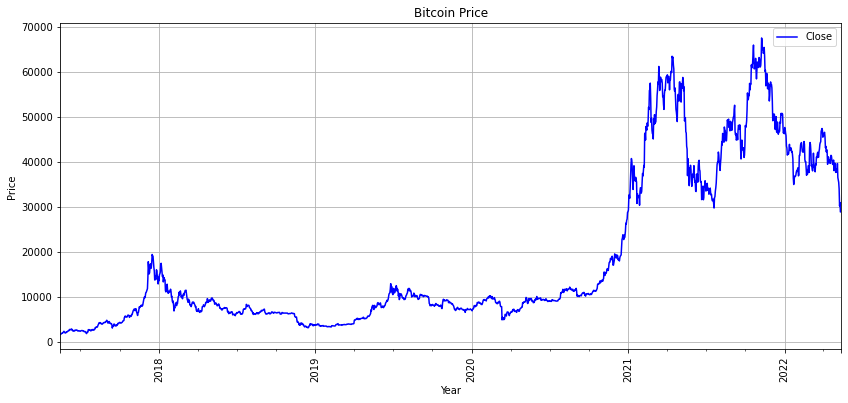

In [3]:
# Visualize 
plt.figure(figsize=[12, 5]);
df.plot( y = 'Close', figsize = (14, 6), color = 'b')
plt.title('Bitcoin Price')
plt.ylabel('Price')
plt.xlabel('Year')
plt.xticks(rotation = 90)
plt.grid(True)
plt.show()

## Stationarity

> For ARIMA model to work, data needs to be stationary:
>	- Mean needs to be constant ( should not go away from the axis over time )
>	- Standard deviation (sigma) is constant ( Fluctuating the same amount )
>    - Covariance is independent of time
>    - No seasonality ( Periodically behaviour )
    
## Check Stationarity ( ADF Test )

We'll use the Augumented Dickey Fuller (ADF) test to check if the time series is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if the p-value > 0.05 we'll need to find the order of differencing.

>- If p-value < 0.05 = Stationary
>- If p-value > 0.05 = Non stationary ( Differencing needed )

In [4]:
# Check if price series is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Close.dropna())
print(f"p-value: {result[1]}")

p-value: 0.5927588737587417


p-value is 0.59 , so differencing is indeed needed.

## Correlation

- Fit the line and check for errors 
- How closely the datapoints are off the line
- High correlated = data points are very close to the line
- Correlation between current price and last days prices

## Autocorrelation

- it takes into consideration the correlation of the time series with itself
- It starts at 1, and data points should center in the autocorrelation plot
- Direct route between prices ( last month to today ) and Indirect route ( day by day )
- Pearson correlation


# ACF plot - AutoCorrelation

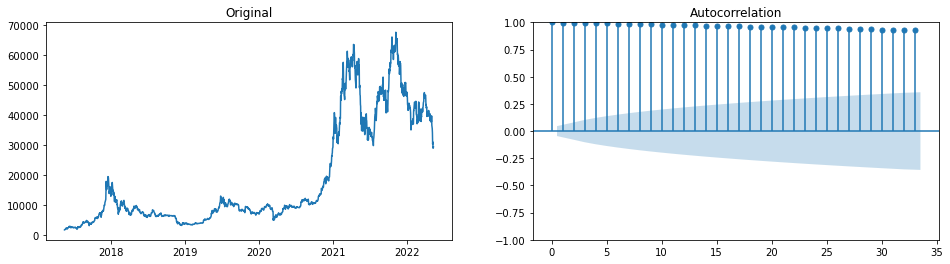

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df.Close)
ax1.set_title("Original")
plot_acf(df.Close, ax=ax2);

## Differencing

Subtracting periodical values

* Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

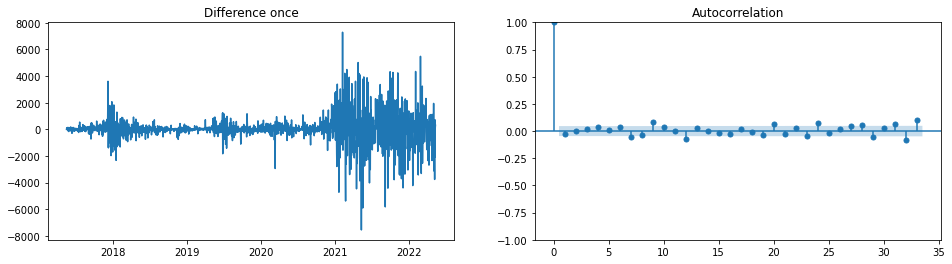

In [6]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2);

## Partial autocorrelation

- Error residuals that are not fit yet ( errors = deviations from the correlation )
- Fit each day leftover error and pass residuals to next day to be fit
- It takes previous days prices to estimate next days errors
- PACF: What is the direct effect of price between previous day and today

## PACF plot

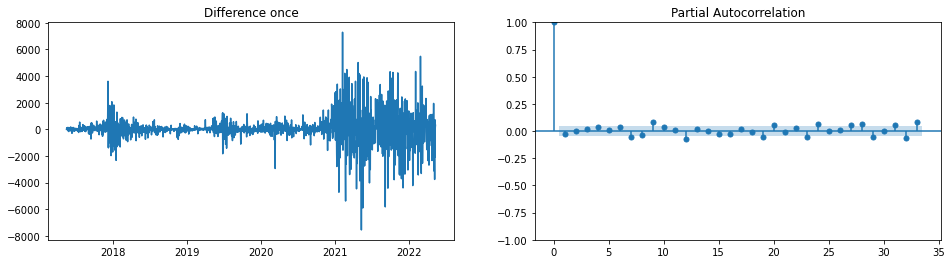

In [7]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

# Fit the model

In [8]:
#Fit model
best_model = SARIMAX(df['Close'], order = (1, 1, 1), seasonal_order = (1, 1, 1, 12)).fit(dis = -1)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 1825
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -15094.714
Date:                            Sat, 14 May 2022   AIC                          30199.429
Time:                                    00:39:45   BIC                          30226.940
Sample:                                05-15-2017   HQIC                         30209.581
                                     - 05-13-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9998      7.571     -0.132      0.895     -15.838      13.839
ma.L1          0.9998      7.324   

## Dataset split to evaluate score

* 85% of the dataset used for training
* 15% of the dataset used for testing

In [9]:
# Divide into train and validation set to calculate R-squared score and mean absolute percentage error 
train = df[:int(0.85 * (len(df)))]
test  = df[int(0.85 * (len(df))):]

train.shape, test.shape

((1551, 6), (274, 6))

## Predict values

* Predict test dataset using the previously trained model.

In [10]:
start = len(train)
end   = len(train) + len(test) - 1
predictions = best_model.predict(start = start, end = end, dynamic = False, typ = 'levels').rename('ARIMA Predictions')
print(predictions)

2021-08-13    44498.247147
2021-08-14    47957.337972
2021-08-15    47080.790365
2021-08-16    47036.890670
2021-08-17    45888.795458
                  ...     
2022-05-09    33955.554671
2022-05-10    30312.441225
2022-05-11    31202.608131
2022-05-12    29041.959102
2022-05-13    28999.280283
Freq: D, Name: ARIMA Predictions, Length: 274, dtype: float64


# R-Squared and MAPE score

>Both methods compare the prediction with the actual prices to generate some sort of accuracy score:

>*  the R2 coefficient of determination is a statistical measure of how well the regression predictions approximate the real data points.
>* The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in statistics.

In [11]:
# Create a dataframe to store r2 score
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['Close'], predictions)}, index = [0])

evaluation_results['MAPE'] = np.mean(np.abs(predictions - test['Close'])
                                                               /np.abs(test['Close']))*100 
# Display the results
evaluation_results

,r2_score,MAPE
0,0.961422,2.551347


## Forecasting 365 days ahead

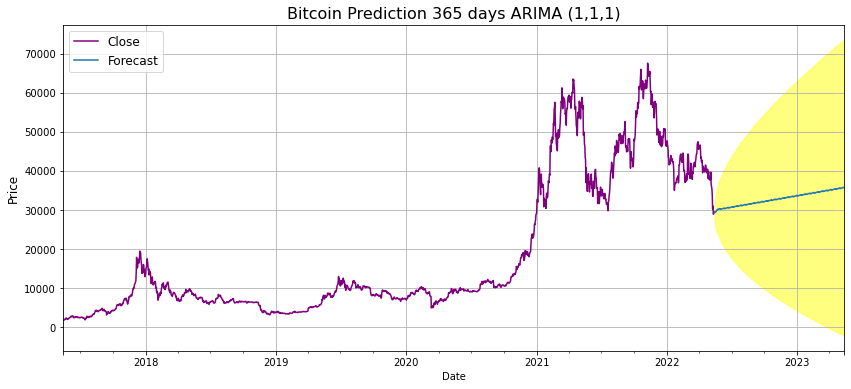

In [12]:
# Forecasting 365 days ahead
forecast_values = best_model.get_forecast(steps = 365)

# Confidence intervals of the forecasted values
forecast_ci = forecast_values.conf_int()

# Plot the data
ax = df.plot(y = 'Close', figsize = (14, 6), legend = True, color = 'purple')

# Plot the forecasted values 
forecast_values.predicted_mean.plot(ax = ax, label = 'Forecast', figsize = (14, 6), grid = True)

# Plot the confidence intervals
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[: , 1], color = 'yellow', alpha = .5)
plt.title('Bitcoin Prediction 365 days ARIMA (1,1,1)', size = 16)
plt.ylabel('Price', size = 12)
plt.legend(loc = 'upper left', prop = {'size': 12})
ax.axes.get_xaxis().set_visible(True)
# annotation
#ax.text(540, 400, 'Forecasted Values Until 2030', fontsize = 12,  color = 'red')
plt.show()

## Conclusion

* We can see that it predicts a straight line and the confidence intervals ( Yellow in the graph ) is quite high and the range  increases according to the amount of days to be predicted, which is expeceted.

* We can conclude that even though the square root score and Mean Absolute Percentage Error are quite good in the testing phase, the model does not perform great for long predictions but show potential for one day ( or data point ) prediction for example.